In [1]:
import torch
from ignite import metrics

In [2]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from pathlib import Path
import pandas as pd

In [3]:
import time

def load_data(path: Path | str):
    '''
    load images and compute metrics against the original
    '''
    if isinstance(path, str): path = Path(path)

    original = cv2.imread(str(path / "original.png"), cv2.IMREAD_COLOR)
    original_tensor = torch.tensor(original, requires_grad=False).permute(2, 0, 1).unsqueeze(0).float().cuda()

    df = pd.DataFrame(columns=["algorithm", "quality", "bits", "mse", "psnr", "ssim"])

    for compressed_img_path in path.glob("*.png"):

        if compressed_img_path.stem == "original": continue

        last3 = compressed_img_path.stem.split("-")[-3:]
        algorithm = last3[0]
        quality = float(last3[1])
        bits = int(last3[2]) 

        compressed_img = cv2.imread(str(compressed_img_path), cv2.IMREAD_COLOR)
        compressed_img_tensor = torch.tensor(compressed_img, requires_grad=False).permute(2, 0, 1).unsqueeze(0).float().cuda()

        mse_metric = metrics.MeanSquaredError()
        mse_metric.update((original_tensor, compressed_img_tensor))
        mse = mse_metric.compute()

        psnr_metric = metrics.PSNR(255)
        psnr_metric.update((original_tensor, compressed_img_tensor))
        psnr = psnr_metric.compute()

        ssim_metric = metrics.SSIM(255)
        ssim_metric.update((original_tensor, compressed_img_tensor))
        ssim = ssim_metric.compute()
        
        del compressed_img_tensor
        torch.cuda.empty_cache()
        del mse_metric
        del psnr_metric
        del ssim_metric
    
        df.loc[len(df)] = [algorithm, quality, bits, mse, psnr, ssim]
    
    del original_tensor
    torch.cuda.empty_cache()

    df = df.sort_values(by=["algorithm", "quality"])
    return df


In [4]:
translations = {
    "ssim": "Structural similarity (SSIM)",
    "mse": "Mean squared error (MSE)",
    "psnr": "Peak signal-to-noise ratio (PSNR)",
    "multicut": "Multicut Encoding",
    "jpg": "JPEG",
    "algorithm": "Algorithm"
}


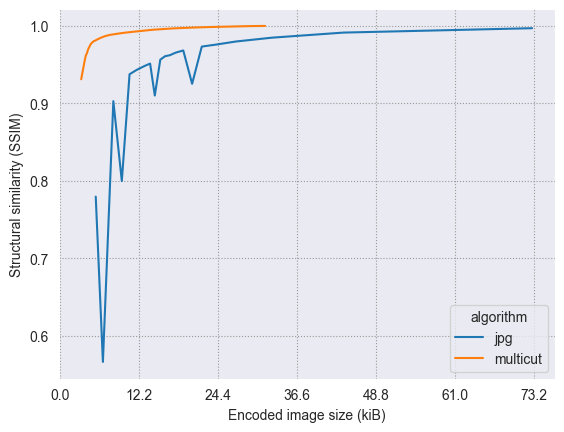

In [13]:
from matplotlib.ticker import FuncFormatter
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

def plot_time_series(df, metric):
    ax = sns.lineplot(
        df, 
        x="bits", 
        y=metric, 
        hue="algorithm", 
        legend="full"
    )
    ax.xaxis.set_major_formatter(FuncFormatter(lambda bits, _: f"{bits / 8192:.1f}"))
    ax.set_xlabel("Encoded image size (kiB)")
    ax.set_ylabel(translations[metric])


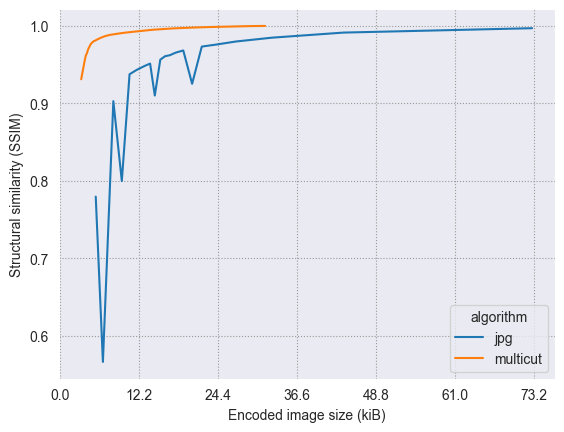

In [25]:
df = load_data(r"results/icon_512/actions-document-save")
plot_time_series(df, "ssim")
plt.savefig("actions-document-save-ssim-timeseries.png", dpi=600)

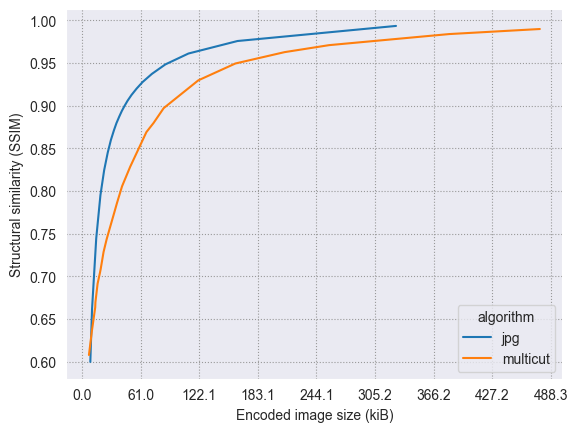

In [17]:
df = load_data(r"results/photo_kodak/kodim19")
plot_time_series(df, "ssim")
plt.savefig("kodim19-ssim-timeseries.png", dpi=600)